### Import relevant libraries

In [13]:
from semopy import Model, calc_stats, semplot
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
import seaborn as sns
from semopy.inspector import inspect


### Import the dataset

In [14]:
df = pd.read_csv("Welzijnsmonitor2025_scaled_normalised_UTF8.csv", sep=";")

### Creating the model

In [15]:
model_desc = """
# measurement model

Wellbeing =~ Bevl_1 + Bevl_2 + Bevl_3 + Cogn_Eng1_5 + Cogn_Eng1_6 + Cogn_Eng2_2 + Cogn_Eng2_3 + Cogn_Eng2_8 + Mot_Stress_1 + Mot_Stress_4
Energy_Sources =~ Bekendgebruik_1 + Bekendgebruik_2 + Bekendgebruik_3 + Bekendgebruik_4 + Bekendgebruik_5 + Bekendgebruik_6 + Bekendgebruik_7 + Cogn_Eng1_1 + Cogn_Eng1_2 + Cogn_Eng1_3 + Cogn_Eng1_4 + Cogn_Eng2_1 + Cogn_Eng2_4 + Cogn_Eng2_5 + Cogn_Eng2_6 + Cogn_Eng2_7 + Hulp_1 + Hulp_2 + Hulp_3 + Partici1_1 + Partici1_2 + Partici1_3 + Partici1_4 + Betrok_Ouders
Negative_Outcomes =~ StopInt + Vertr
Positive_Outcomes =~ Cijfer_huidig_1 + Stopint2
Stressors =~ Cantrill_1 + Leefst + Q297_1 + Onnodige_stress_1 + Onnodige_stress_2 + Onnodige_stress_3 + Onnodige_stress_4 + Onnodige_stress_5 + Onnodige_stress_6 + Onnodige_stress_7 + Onnodige_stress_8 + Onnodige_stress_9 + Onnodige_stress_10 + Werk_1
Response_to_Stress =~ Burn1_1 + Burn1_2 + Burn1_3 + Burn1_4 + Depr_1 + Depr_2 + Depr_3 + Depr_4 + Depr_5 + Depr_6 + Depr_7 + Depr_8 + Mot_Stress_2

# Covariances (two-headed arrows in the diagram)
Stressors ~~ Energy_Sources
Response_to_Stress ~~ Wellbeing

# Regressions
Response_to_Stress ~ Stressors + Energy_Sources
Wellbeing        ~ Stressors + Energy_Sources

Negative_Outcomes ~ Response_to_Stress + Wellbeing
Positive_Outcomes ~ Wellbeing + Response_to_Stress
"""

In [16]:
model = Model(model_desc)
model.fit(df)

df_imputed = model.predict(df)
latent_scores = model.predict_factors(df_imputed)

# Export the model with the new latent variables and their descriptive statistics

In [17]:
latent_scores.to_csv("latent_variable_scores.csv", index=False)
latent_scores.describe()

,Energy_Sources,Negative_Outcomes,Positive_Outcomes,Response_to_Stress,Stressors,Wellbeing
count,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03,1.512000e+03
mean,3.289550e-17,-2.937098e-17,-5.874196e-17,-4.699357e-17,-4.111937e-18,1.926736e-16
std,2.188961e-01,2.031211e-01,9.900401e-02,5.969003e-01,1.584999e-01,5.321402e-01
min,-8.639226e-01,-4.562207e-01,-4.017283e-01,-1.495058e+00,-4.231895e-01,-2.156158e+00
25%,-1.408574e-01,-1.470404e-01,-5.195456e-02,-4.454998e-01,-1.141686e-01,-2.820566e-01
50%,-3.170985e-03,-4.589377e-02,1.501249e-02,-4.621420e-02,-6.735650e-03,8.211317e-02
75%,1.376822e-01,1.100375e-01,6.538193e-02,3.903470e-01,1.094316e-01,3.499913e-01
max,7.912207e-01,8.479881e-01,2.527539e-01,2.122493e+00,7.213656e-01,1.363592e+00


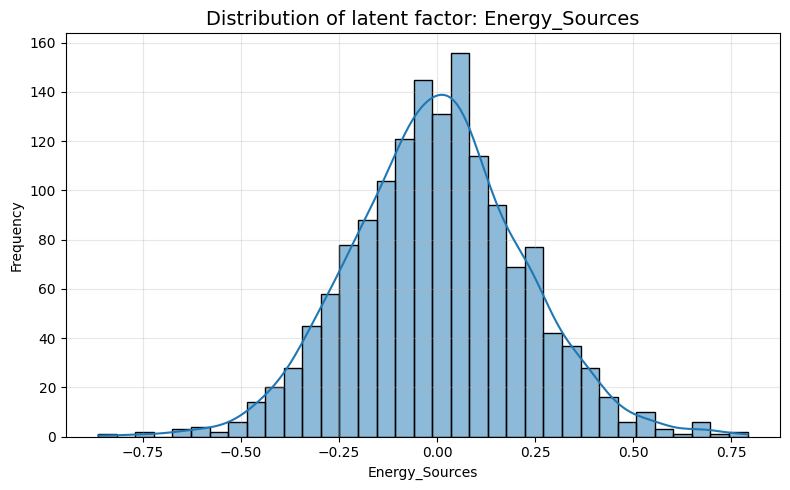

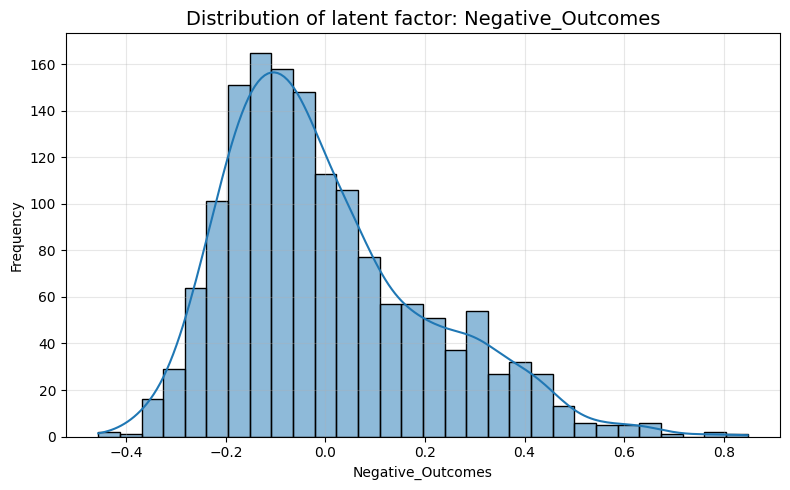

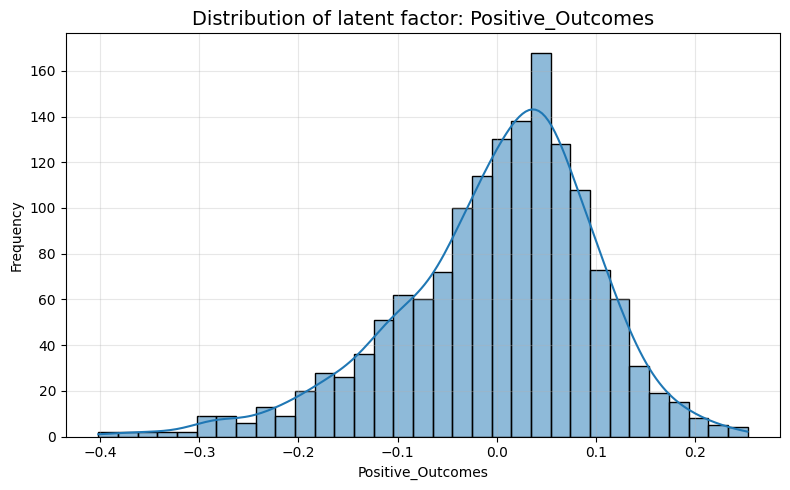

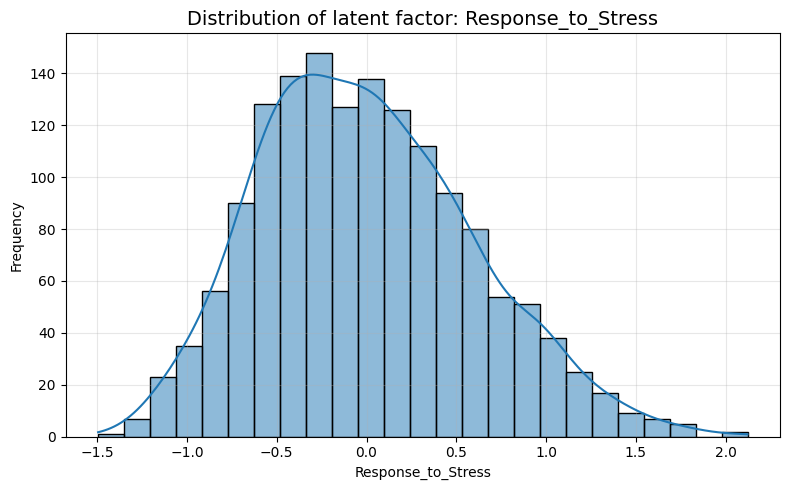

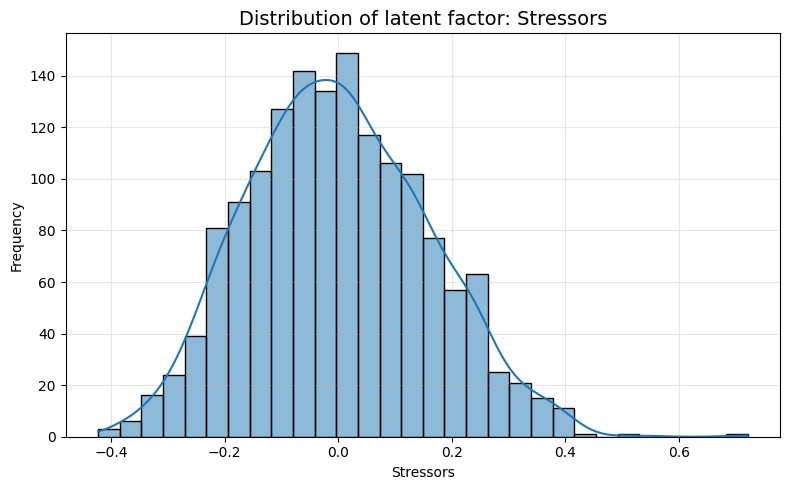

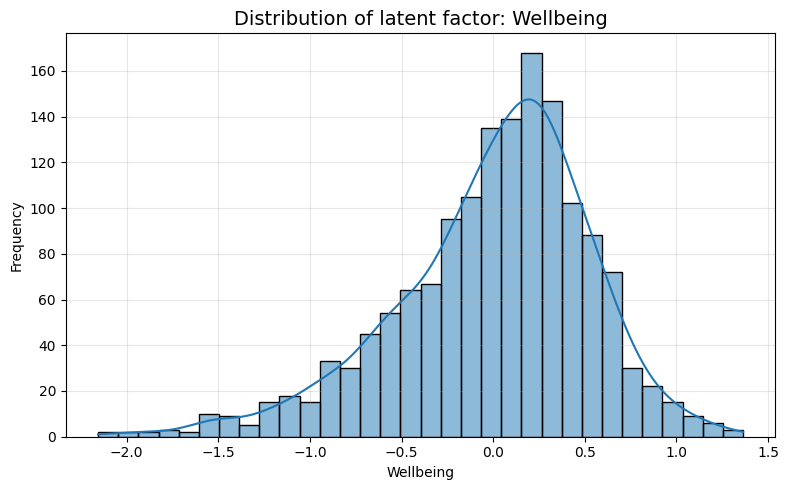

In [18]:
# Plot histogram for each latent variable
for col in latent_scores.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(latent_scores[col], kde=True)
    plt.title(f"Distribution of latent factor: {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

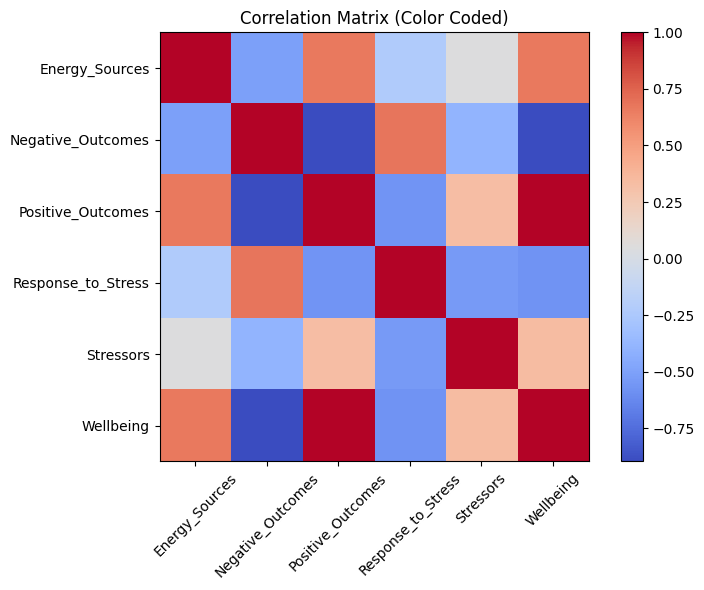

In [19]:
# Correlation matrix
corr_matrix = latent_scores.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
plt.title("Correlation Matrix (Color Coded)")
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.tight_layout()
plt.show()

### Calculate fit indices

In [20]:
stats = calc_stats(model)

print("=== Model Fit Statistics ===")
print(stats.T)

=== Model Fit Statistics ===
                      Value
DoF             2005.000000
DoF Baseline    2080.000000
chi2           16032.529184
chi2 p-value       0.000000
chi2 Baseline  36158.108108
CFI                0.588371
GFI                0.556599
AGFI               0.540013
NFI                0.556599
TLI                0.572974
RMSEA              0.068046
AIC              258.792951
BIC             1003.759349
LogLik            10.603525


### Create and save the path diagram

In [21]:
g = semplot(model, "pd3.png")

In [22]:
# print(g)

In [23]:
# Extract model coefficients
coefficients = model.inspect()
coefficients.to_csv("model_coefficients.csv")
coefficients.to_excel("model_coefficients.xlsx")

In [24]:
def pretty_sem_latent_explicit(model):
    df = model.inspect().copy()

    # List of latent relationships as (lval, op, rval)
    wanted = [
        # covariances
        ("Stressors",          "~~", "Energy_Sources"),
        ("Response_to_Stress", "~~", "Wellbeing"),

        # regressions
        ("Response_to_Stress", "~",  "Stressors"),
        ("Response_to_Stress", "~",  "Energy_Sources"),
        ("Wellbeing",          "~",  "Stressors"),
        ("Wellbeing",          "~",  "Energy_Sources"),
        ("Negative_Outcomes",  "~",  "Response_to_Stress"),
        ("Negative_Outcomes",  "~",  "Wellbeing"),
        ("Positive_Outcomes",  "~",  "Response_to_Stress"),
        ("Positive_Outcomes",  "~",  "Wellbeing"),
    ]

    wanted_df = pd.DataFrame(wanted, columns=["lval", "op", "rval"])

    # Inner join to keep only those rows
    df = df.merge(wanted_df, on=["lval", "op", "rval"], how="inner")

    # Label type + from/to
    df["Type"] = df["op"].map({"~": "Regression", "~~": "Covariance"})
    df["From"] = df["lval"]
    df["To"]   = df["rval"]

    # Clean p-values (handles "<0.001")
    p_clean = df["p-value"].astype(str).str.replace("<", "", regex=False)
    df["p_value"] = pd.to_numeric(p_clean, errors="coerce")

    # Significance stars
    def stars(p):
        if pd.isna(p): return ""
        if p < 0.001: return "***"
        if p < 0.01:  return "**"
        if p < 0.05:  return "*"
        if p < 0.10:  return "."
        return ""

    df["Sig"] = df["p_value"].apply(stars)

    # Numeric & rounded
    for col in ["Estimate", "Std. Err", "z-value", "p_value"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").round(4)

    # Final table
    nice = df[[
        "Type", "From", "To",
        "Estimate", "Std. Err", "z-value", "p_value", "Sig"
    ]].copy()

    nice = nice.rename(columns={"Std. Err": "Std_Err"})

    return nice

latent_table = pretty_sem_latent_explicit(model)
latent_table   # last line in the cell → shows a nice table

,Type,From,To,Estimate,Std_Err,z-value,p_value,Sig
0,Regression,Response_to_Stress,Stressors,-1.8358,0.2189,-8.3851,0.0000,***
1,Regression,Response_to_Stress,Energy_Sources,-0.4421,0.0930,-4.7552,0.0000,***
2,Regression,Wellbeing,Stressors,0.9185,0.1279,7.1833,0.0000,***
3,Regression,Wellbeing,Energy_Sources,1.3177,0.1886,6.9855,0.0000,***
4,Regression,Negative_Outcomes,Response_to_Stress,0.0842,0.0186,4.5251,0.0000,***
5,Regression,Negative_Outcomes,Wellbeing,-0.2780,0.0232,-12.0031,0.0000,***
6,Regression,Positive_Outcomes,Wellbeing,0.1870,0.0264,7.0816,0.0000,***
7,Regression,Positive_Outcomes,Response_to_Stress,0.0015,0.0157,0.0969,0.9228,
8,Covariance,Stressors,Energy_Sources,0.0014,0.0013,1.0992,0.2717,
9,Covariance,Response_to_Stress,Wellbeing,-0.0995,0.0092,-10.8131,0.0000,***
